# Hotel Lift Traffic: Monte Carlo simulation

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import logging
import random
import math

logging.getLogger().setLevel(logging.DEBUG)
logging.debug("TEST")

%matplotlib inline

In [2]:
# make a rules using graph network
lift_number = 4
number_of_floor = 20
conference_room_floor = 2

In [9]:
class RoomType:
    def __init__(self,name_type:str,capacity:int):
        self._name_type=name_type
        self._capacity=capacity
    
    @property
    def name_type(self):
        return self._name_type
    
    @property
    def capacity(self):
        return self._capacity


        
class RandomDist():
    def __init__(self,name):
        self._name = name

    @property
    def name(self):
        return self._name
    
    def random(self):
        None
    
class GaussianDist(RandomDist):
    def __init__(self,mu:float,sigma:float,low:float,high:float):
        RandomDist.__init__(self,"Gaussian")
        self._mu = mu
        self._sigma = sigma
        self._low = low
        self._high = high
        
    def random(self):
        x = self._low - 1
        while x < self._low or x > self._high:
            x = random.gauss(self._mu,self._sigma)                        
        return x
    
class GaussianDiscrete(RandomDist):
    def __init__(self,mu:float,sigma:float,low:float,high:float):
        RandomDist.__init__(self,"GaussianDiscrete")
        self._mu = mu
        self._sigma = sigma
        self._low = low
        self._high = high
        
    def random(self):
        x = self._low - 1
        while x < self._low or x > self._high:
            x = math.round(random.gauss(self._mu,self._sigma))
        return x

class CapacityLimit:
    def __init__(self,capacity = 0):
        self._capacity = capacity
    
    @property
    def capacity(self):
        return self._capacity

class Floor(CapacityLimit):
    def __init__(self,capacity = 0):
        CapacityLimit.__init__(self,capacity)
    
class HotelFloor(Floor):
    def __init__(self,floor_name:str,rooms_floor_count: dict,room_types: dict):
        self._rooms = {}
        number = 1
        self._floor_name = floor_name
        
        capacity = 0
        # initialize room type
        for key in rooms_floor_count:
            self._rooms[key] = []
        # create the Room object
        for key in rooms_floor_count:
            for i in range(rooms_floor_count[key]):
                room = Room(str(floor_name)+str(number),room_types[key].name_type,room_types[key].capacity,floor=self)
                self._rooms[key].append(room)
                capacity += room.capacity
                number+=1
        
        self._total_rooms = number
        
        Floor.__init__(self,capacity)
    
    @property
    def rooms(self):
        return self._rooms
    
    @property
    def floor_name(self):
        return self._floor_name
    
    def __repr__(self):
        return "Floor: {}, Total Rooms: {}".format(self.floor_name,self._total_rooms)

    
class Room(RoomType):
    """
    def __init__(self,number: str,room_type: RoomType):
        self._room_type = room_type
        self._number = number        
        
    @property
    def room_type(self):
        return self._room_type
    """
        
    def __init__(self,number: str,name:str,capacity:int,floor:HotelFloor):
        RoomType.__init__(self,name,capacity)
        self._number = number
        self._occupied = False
        self._attendance = []
        self._floor = floor
    
    @property
    def floor(self):
        return self._floor
    
    @property
    def number(self):
        return self._number
                    
    @property
    def occupied(self):
        return self._occupied

    """
    @occupied.setter
    def occupied(self,status:bool):
        self._occupied = status
    """
    
    @property
    def attendance(self):
        return self._attendance
    
    @property
    def attendance_number(self):
        return len(self._attendance)
    
    @property
    def occupied_status(self):
        return "occupied" if self.occupied else "empty"
    
    def attendance_checkin(self,person:Person):
        self.attendance.append(person)
        # There is a person checkin, set occupancy status of this room into True
        if self.attendance_number > 0:
            self._occupied = True
    
    def attendance_checkout(self,person:Person):
        self.attendance.remove(person)
        # if attendance number is zero than the room is empty
        if self.attendance_number == 0:
            self._occupied = False

    def __repr__(self):
        return("Room {}, Type: {}, Capacity: {}, Status: {}".format(self.number,self.name_type,self.capacity,self.occupied_status))    
        
class Lift(CapacityLimit):
    _status_list = ["go_up","go_down","idle"]
    
    def __init__(self,name:str,average_speed:int=1,
                 floor_configuration:dict={},capacity:int = 0,position:int = 0,
                 max_waiting_time:int=10):
        CapacityLimit.__init__(self,capacity)
        self._name = name
        self._position = position
        self._graph = nx.DiGraph()
        self._attendance = 0
        self._max_waiting_time = 10
        self._timer = 0

        # variables for moving act
        self._status = "idle"
        self._target = ""
        self._action = ""
        self._stop_floor = []
        
        # Random distribution for maximum waiting time
        # it should use skewed distribution
        # This will effect the lift door closing time
        
        self._random_gauss = GaussianDist(mu = self.max_waiting_time/2, sigma=5, low=1, high=self.max_waiting_time)

        if len(floor_configuration) > 0:
            # floor configuration is exist
            # we can make a fully customized lift graph
            logging.debug(floor_configuration)
            self._served_floor = floor_configuration["floor"]
            for i,x in enumerate(floor_configuration["floor"]):
                self.graph.add_node(x)
                if i > 0:
                    previous_floor = floor_configuration["floor"][i-1]
                    speed = floor_configuration["speed"][i-1]
                    self.graph.add_edge(previous_floor,x,attr={"speed": speed, "dir": "up"})
                    self.graph.add_edge(x,previous_floor,attr={"speed": speed, "dir": "down"})
    
    @property
    def max_waiting_time(self):
        return self._max_waiting_time
    
    @property
    def random_gauss(self) -> GaussianDist :
        return self._random_gauss
    
    def gen_close_door(self) -> int :
        """
        Generate close door for simulation
        """
        return math.ceil(self._random_gauss.random())
                    
    @property
    def waiting_time(self) -> int :
        return self._waiting_time
                    
    @property
    def name(self) -> str :
        return self._name
    
    @property
    def position(self) -> int : 
        return self._position
    
    @position.setter
    def position(self,position) -> int :
        self._position = position
        
    @property
    def graph(self) -> nx.DiGraph : 
        return self._graph
    
    @property
    def attendance(self) -> int : 
        return self._attendance

    @property
    def served_floor(self) -> list:
        return self._served_floor
    
    @attendance.setter
    def attendance(self, new_att:int):
        if new_att > self.capacity:
            raise Exception("Attendance reach it's maximum capacity: {}".format(self.capacity))
        if new_att < 0:
            raise Exception("Attendance can't be lower than zero: {}".format(new_att))
        """
        if self.attendance + new_att > self.capacity:
            throw Exception("Attendance reach it's maximum capacity: {}".format(self.capacity))
        """
        self._attendance = new_att
    
    def add_attendance(self,new_att: int):
        self.attendance+=new_att
    
    def pop_attendance(self,drop_att: int):
        self.attendance-=drop_att            
    
    def go_up(self):
        """
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "up":
                self.position = target_node
        return self.position
        """
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "up":
                self._target = target_node
                self._timer+=edge[target_node]["attr"]["speed"]
        return self._targetsp
    
    def go_down(self):
        """
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "down":
                self.position = target_node
        return self.position
        """
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "down":
                self._target = target_node
                self._timer+=edge[target_node]["attr"]["speed"]
        return self._target
    
    def call(self,floor):
        """
        Lift is called to particular floor,
        append the floor to the stop list
        """
        if floor not in self._stop_floor:
            if self._status=="idle":
                # check which direction the lift should move
                path = nx.shortest_path(self._graph,self._position,floor)
                self._status = edge[path[0]][path[1]]["attr"]["dir"]
            self._stop_floor.append(floor)
            
    def goto(self,floor):
        """
        Same operation with call, just to make variance statement
        between calling and pushing the button inside lift
        """
        self.call(floor)
    
    def perform_move(self):
        
        """
        check the stop_floor, if the lift is called to stop at that floor, 
        perform waiting time generator
        """
        if self._timer==0:
            # if there is no stop call
            if len(self._stop_floor) == 0:
                self._status = "idle"
            elif self._position in self._stop_floor:
                # remove the position from the stop floor
                self._stop_floor.remove(self._position)
                # perform additional waiting time
                self._timer+=self.gen_close_door()
        
        """
        move the lift
        """
        if self._status == "up":
            self.go_up()
        elif self._status == "down":
            self.go_down()
        
        if self._timer > 0:
            self._timer-=1            

    def __repr__(self):
        #print(self.served_floor)
        return "Lift {}, capacity: {}, attendance: {}, position: {}, serve: {}".format(self.name,self.capacity,self.attendance,self.position,",".join([str(x) for x in self.served_floor])) 
        
        
number_of_floor = 20

custom_floor = [0,10]
custom_floor.extend(range(11,number_of_floor))
custom_speed = [10]
custom_speed.extend([1 for x in range(10,number_of_floor-1)])


lift_floor_configuration = {
    # speed 1 for every floor
    0: { "floor": range(0,number_of_floor), "speed": [1 for x in range(number_of_floor-1)] },
    1: { "floor": range(0,number_of_floor), "speed": [1 for x in range(number_of_floor-1)] }, 
    2: { "floor": range(0,int(number_of_floor/2)), "speed": [1 for x in range(0,int(number_of_floor/2)-1)] },
    3: { "floor": range(0,int(number_of_floor/2)), "speed": [1 for x in range(0,int(number_of_floor/2)-1)] },
    4: { "floor": custom_floor, "speed": custom_speed },
    5: { "floor": custom_floor, "speed": custom_speed }
}

room_types_list = ["single","double","deluxe"]

room_types = {
    "single": RoomType("single",2),
    "double": RoomType("double",2),
    "deluxe": RoomType("deluxe",4),
}

rooms_floor_count = {
    "single" : 20,
    "double" : 20,
    "deluxe" : 10
}    
    
class HotelLift():    
    def __init__(self,number_of_floor:int,number_of_lift:int,rooms_floor_count,room_types:dict):
        self._floors = []
        self._rooms = []
        self._total_capacity = 0
        for x in range(number_of_floor):
            floor = HotelFloor(x,rooms_floor_count,room_types)
            self._total_capacity += floor.capacity
            self._floors.append(floor)
            #print(floor.rooms)
            for rooms in floor.rooms.values():
                #print(rooms)
                self._rooms.extend(rooms)
        
        self._lifts = {}
        for x in lift_floor_configuration:
            logging.debug(x)
            config = lift_floor_configuration[x]
            self.lifts[x] = Lift(name=x,floor_configuration=config,capacity=20,position=0)
                
        """
        for x in range(number_of_lift):
            lift = Lift(x,20,0)
            for y in range(number_of_floor):
                lift.graph.add_node(y)
                if y > 0:
                    lift.graph.add_edge(y-1,y)
                    lift.graph.add_edge(y,y-1)

            self._lifts.append(lift)     
        """
        
    @property
    def lifts(self):
        return self._lifts
    
    @property
    def floors(self):
        return self._floors
    
    @property
    def rooms(self):
        return self._rooms
    
    @property
    def total_capacity(self):
        return self._total_capacity
        
    def __repr__(self):
        output = ""
        for x in self.lifts.values():
            output += x.__repr__() + "\n"
        return output                        

def HotelLiftQueue():
    def __init__(self,hotel_lift:HotelLift):
        self._hotel_lift = hotel_lift
        
    @property
    def hotel_lift(self):
        return self._hotel_lift
    
    
    
def create_lift(number_of_floor:int):
    one_lift = nx.DiGraph()
    for x in range(number_of_floor):
        one_lift.add_node(x)
        if x > 0:
            one_lift.add_edge(x-1,x)
            one_lift.add_edge(x,x-1)
    return one_lift

(array([   1.,    5.,    7.,   19.,   29.,   50.,   76.,  120.,  138.,
         148.,  132.,  109.,   69.,   46.,   26.,   13.,    8.,    2.,
           0.,    2.]),
 array([-14526.66655973, -10699.7189799 ,  -6872.77140006,  -3045.82382023,
           781.1237596 ,   4608.07133944,   8435.01891927,  12261.96649911,
         16088.91407894,  19915.86165878,  23742.80923861,  27569.75681845,
         31396.70439828,  35223.65197812,  39050.59955795,  42877.54713779,
         46704.49471762,  50531.44229745,  54358.38987729,  58185.33745712,
         62012.28503696]),
 <a list of 20 Patch objects>)

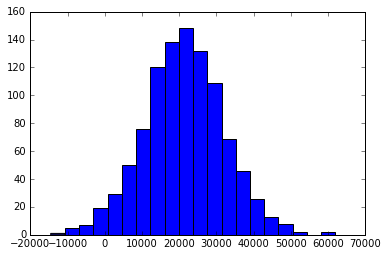

In [10]:
# moving time generator simulation
y = []
for i in range(1000):
    #y.append(x.lifts[0].gen_close_door())
    #print(i)
    y.append(random.gauss(21600,21600/2))
plt.hist(y,bins=20)

In [11]:
class Person():
    _target_dest = ["room","outside","conference","dining"]
    _status = ["idle","go_lift","waiting_lift","in_lift","on_move"]
    
    # Create a DAG for moving behaviour
    
    _nodes = ["room","go_lift","waiting_lift","in_lift","outside"]    
    
    _move_graph = nx.DiGraph()
    for node in _nodes:
        _move_graph.add_node(node)
    
    _move_graph.add_edge("room","go_lift")
    _move_graph.add_edge("go_lift","waiting_lift")
    _move_graph.add_edge("waiting_lift","in_lift")    
    _move_graph.add_edge("in_lift","outside")
    _move_graph.add_edge("outside","go_lift")
    _move_graph.add_edge("in_lift","room")        
    
    def __init__(self,name:str,move_time:int,outside_time:int,schedule={},capacity_unit=1):
        self._name = name
        self._capacity_unit = capacity_unit
        self._schedule = schedule
        self._move_time = move_time
        self._outside_time = outside_time        
        self._random_move_time = GaussianDist(mu=move_time,sigma=move_time/2,low=0,high=move_time*2)
        self._random_outside_time = GaussianDist(mu=outside_time,sigma=outside_time/2,low=0,high=outside_time*2)
        self._next_move = 0

        """
        status for a person is
        
        """
        self._status = "idle"
        self._position = "outside"
        self._target = ""
        self._action = ""
        self._moving_path = []
        
    @property
    def capacity_unit(self):
        return self._capacity_unit
    
    @property
    def name(self):
        return self._name
    
    @property
    def move_time(self):
        return self._move_time
    
    @property
    def next_move_schedule(self):
        return self._next_move
    
    @property
    def status(self):
        return self._status       
    
    def perform_move(self):
        """
        This function will be a counter time for moving
        every time this function called, moving time will be reduced
        and if it's reach zero it will perform the moving
        action
        """
        if self._move_time == 0 and self._moving_path[0] == self._position:
            # pop the value
            self._moving_path.pop(0)
            self._action = self._moving_path[0]
        
        if len(self._moving_path)==0:
            self.generate_next_move()
                    
        if self._move_time > 0:
            self._move_time-=1        
    
    @property
    def target(self):
        return self._target
    
    @property
    def position(self):
        return self._position
    
    @position.setter
    def position(self,pos:str):
        self._position = pos
    
    @property
    def action(self):
        return self._action
    
    def generate_next_move(self):
        if self._position == "room":
            self._next_move = self._random_move_time.random()
            self._target = "outside"
        else:
            self._next_move = self._random_outside_time.random()
            self._target = "room"
        
        self._moving_path = nx.shortest_path(self._move_graph,self._position,self._target)        

    
class Attendance(Person):
    def __init__(self,room:Room,name:str,move_time:int,outside_time:int,schedule:dict={},capacity_unit:int=1):
        Person.__init__(self,name,move_time=move_time,outside_time=outside_time,capacity_unit=capacity_unit,schedule=schedule)
        self._room = room
    
    @property
    def room(self):
        return self._room
    
    @room.setter
    def room(self,room:Room):
        self._room = room
    
    def __repr__(self):
        return "name: {}, room: {}".format(self.name,self.room)

In [12]:
#HotelFloor(rooms_floor_count,room_types)
hotel = HotelLift(20,4,rooms_floor_count,room_types)
print(hotel)
len(hotel.rooms)

Lift 0, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 1, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 2, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 3, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 4, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19
Lift 5, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19



1000

In [13]:
class InitialGenerator():
    def __init__(self,room_stack: list,room_occupancy_pctg:float,move_time:int,outside_time:int):
        # sample room_stack based on occupancy percentage
        total_rooms = len(room_stack)
        occupied_index = np.random.randint(total_rooms,size=np.int(room_occupancy_pctg*total_rooms))
        self._room_stack = room_stack
        logging.debug(occupied_index)
        #occupied = [room_stack[x] for x in occupied_index]
        self._attendance = []
        number = 0
        for i in occupied_index:
            room = room_stack[i]
            #room.occupied = True
            # for every room occupied, create attendance person based on the capacity
            number_of_attendance = np.random.randint(room.capacity) + 1
            #print(room)
            for j in range(number_of_attendance):
                # create new attendance
                new_att = Attendance(room,number,move_time=move_time,outside_time=outside_time)
                new_att.position = "room"
                room.attendance_checkin(new_att)
                self._attendance.append(new_att)
                number+=1
    
    @property
    def attendance(self):
        return self._attendance
    
    @property
    def room_stack(self):
        return self._room_stack
    
    @property
    def number_of_attendance(self):
        return len(self._attendance)

In [38]:
from pynput import keyboard
import threading

class SimulationHelper():
    def __init__(self, attendance: list, hotel_lift: list, interval :float = 0.1):
        self._attendance = attendance
        self._hotel_lift = hotel_lift
        self._status = "stop"
        self._interval = interval
        
        self._timer = threading.Timer(self._interval,self.run_simulation)

    def on_press(self,key):
        try:
            print('alphanumeric key {0} pressed'.format(
                key.char))
        except AttributeError:
            print('special key {0} pressed'.format(
                key))

    def on_release(self,key):
        print('{0} released'.format(
            key))
        if key == keyboard.Key.cmd:
            if self._status == "start":
                self.stop()
                #self._timer.wait()
            else:
                if not self._timer.is_alive():
                    self._timer = threading.Timer(self._interval,self.run_simulation)                    
                    self.start()
                #self._timer.start()
        #if key == keyboard.Key.esc:
            # Stop listener
        #    return False        
        
    def simulate_timer(self):
        # move all the object
        #logging.debug(self._attendance)
        for attendance in self._attendance:
            attendance.perform_move()
        
        for lift in self._hotel_lift.values():
            lift.perform_move()            
    
    def run_simulation(self):
        while self._status == "start":
            #print(self._status)
            self.simulate_timer()
        print(self._status)
        self._timer.cancel()
    
    def run(self,duration = 3600):
        # Collect events until released        
        self.start()
        with keyboard.Listener(
                on_press=self.on_press,
                on_release=self.on_release) as listener:
            """
            while self._status == "start":
                print(self._status)
    #        for i in range(duration):
                self.simulate_timer()               
            """
            listener.join()        
            # check stop signal
    
    def start(self):
        self._status = "start"
        # run the timer again
        if not self._timer.is_alive():
            self._timer.start()
        
    def stop(self):
        self._status = "stop"            

In [39]:
simulate = InitialGenerator(room_stack=hotel.rooms,room_occupancy_pctg=0.8,move_time=14400,outside_time=3600)

In [40]:
simulate.attendance
print(simulate.number_of_attendance)

1391


In [41]:
helper = SimulationHelper(attendance=simulate.attendance,hotel_lift=hotel.lifts)

In [42]:
#helper.start()
helper.run()

Key.shift released
special key Key.cmd pressed
Key.cmd released
stop
special key Key.cmd pressed
Key.cmd released
special key Key.cmd pressed
Key.cmd released
stop
special key Key.cmd pressed
Key.cmd released
special key Key.cmd pressed
Key.cmd released
stop
special key Key.cmd pressed
Key.cmd released
special key Key.cmd pressed
Key.cmd released
stop


KeyboardInterrupt: 

In [121]:
print(hotel.rooms[0].attendance)
hotel.total_capacity

[name: 2, room: Room 01, Type: single, Capacity: 2, Status: occupied, name: 405, room: Room 01, Type: single, Capacity: 2, Status: occupied, name: 406, room: Room 01, Type: single, Capacity: 2, Status: occupied]


2400

In [17]:
class AttendanceGenerator():    
    def __init__(self,room_stack : list,checkin_time:int, checkout_time:int, checkin_time_range:int, checkout_time_range:int, stay_range:int):
    #def __init__(self,time_range:int):
        """
        checkin_time: time in seconds format each day
        time_range: is distribution time between each attendance
        """
        self._room_stack = room_stack
        #self._dist_time = dist_time
        self._time_range = time_range
        self._checkin_time = checkin_time
        self._generate_checkin = GaussianDist(mu=checkin_time_range*2/3,sigma=800,low=0,high=checkin_time_range*3/2)
        self._generate_checkout = GaussianDist(mu=checkout_time_range*1/3,sigma=800,low=0,high=checkout_time_range*3/2)
        self._generate_stay = celana
        #self._generate = GaussianDist(mu=time_range*2/3,sigma=800)
        for room in self.room_stack:            
            room["checkin_time"] = self.checkin_time + self.generate()
#            room["checkout_time"] = 
    
    @property
    def checkin_time(self):
        return self._checkin_time
    
    @property
    def room_stack(self):
        return self._room_stack
    
    @property
    def dist_time(self):
        return self._dist_time
    
    def generate(self):
        return math.ceil(self._generate.random())
    
#    def 
    
#class 

In [6]:
?random.gauss()
x = AttendanceGenerator(room_stack=[],time_range=3600)
x.generate()

2621

In [171]:
#HotelFloor(rooms_floor_count,room_types)
x = HotelLift(20,4,rooms_floor_count,room_types)
print(x)

Lift 0, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 1, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 2, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 3, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 4, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19
Lift 5, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19



In [173]:
x.lifts[0].go_down()
len(x._rooms)
#x._total_capacity

1000

(array([   3.,    8.,   10.,   25.,   39.,   47.,   78.,  115.,  131.,
         134.,  125.,  105.,   83.,   40.,   23.,   22.,    4.,    5.,
           1.,    2.]),
 array([ 4775.  ,  5030.65,  5286.3 ,  5541.95,  5797.6 ,  6053.25,
         6308.9 ,  6564.55,  6820.2 ,  7075.85,  7331.5 ,  7587.15,
         7842.8 ,  8098.45,  8354.1 ,  8609.75,  8865.4 ,  9121.05,
         9376.7 ,  9632.35,  9888.  ]),
 <a list of 20 Patch objects>)

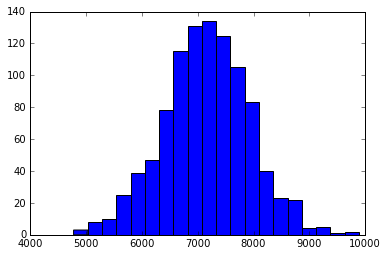

In [190]:
y = []
x = AttendanceGenerator(room_stack=[],time_range=10800)
for i in range(1000):
    #y.append(x.lifts[0].gen_close_door())
    #print(i)
    y.append(x.generate())
plt.hist(y,bins=20)

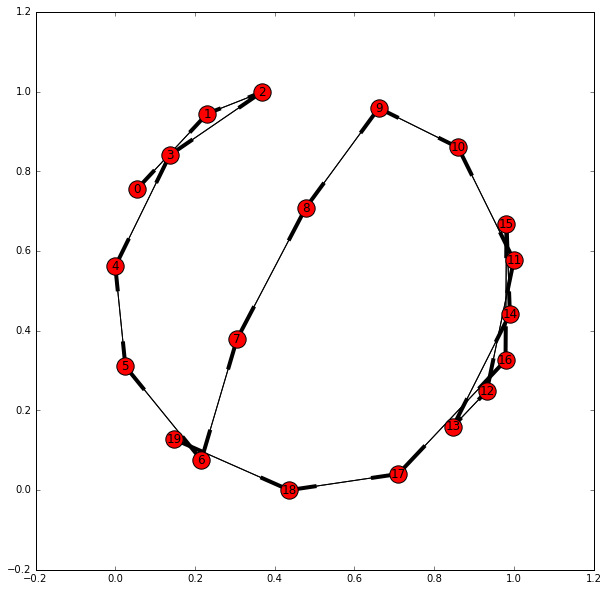

In [203]:
one_lift = create_lift(20)
plt.figure(figsize=(10,10))
nx.draw_networkx(one_lift,pos=nx.spring_layout(one_lift))
plt.show()

In [23]:
# make a graph network of the floor
lifts_graph = []
for x in range(lift_number):
    lifts_graph.append(create_lift(number_of_floor))

In [24]:
lifts_graph